# Determining quantum bounds

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ncpol2sdpa import generate_variables, SdpRelaxation
from scipy.optimize import minimize_scalar
from joblib import Parallel, delayed
import json

In [2]:
# Define quantum operators
A = [generate_variables(f"A{i}", 1)[0] for i in range(2)]
B = [generate_variables(f"B{i}", 1)[0] for i in range(2)]
ops = A + B

# Constraints
op_eqs = [op**2 - 1 for op in ops]
op_ineqs = []
moment_eqs = []
moment_ineqs = []

# Compute quantum value of Bell expression at (p1, p4) for a given Theta
def compute_beta(p1, p4, Theta):
    s = np.sqrt(2)
    tan_2T = np.tan(2 * Theta)
    sin_2T = np.sin(2 * Theta)
    cos_2T = np.cos(2 * Theta)
    cos_4T = np.cos(4 * Theta)
    sin_4T = np.sin(4 * Theta)

    beta_expr = 1/16 * (
        4 * (s * (B[0] + B[1]) / (tan_2T * sin_2T) + 4 * p1 * A[0] + 8 * p4 * A[1]) +
        (4 / s) / (sin_2T ** 2) * (
            (B[0] + B[1]) * (-3 + cos_4T) * p1
            - 2 * A[0] * B[0] * (cos_4T - p1 * cos_2T)
            - 2 * A[0] * B[1] * (cos_4T - p1 * cos_2T)
            + 2 * sin_2T * (
                4 * (-B[0] + B[1]) * p4 * sin_2T ** 2
                + A[1] * B[1] * (-1 + cos_2T * p1 - 2 * p4 * sin_4T)
                - A[1] * B[0] * (-1 + cos_2T * p1 + 2 * p4 * sin_4T)
            )
        )
    )

    sdp = SdpRelaxation(ops, verbose=0)
    sdp.get_relaxation(
        level=2,
        equalities=op_eqs,
        inequalities=op_ineqs,
        momentequalities=moment_eqs,
        momentinequalities=moment_ineqs,
        objective=-beta_expr
    )
    sdp.solve(solver="mosek")
    return -sdp.dual

# Minimize r for fixed φ and Theta
def minimize_r(phi, Theta):
    def objective(r):
        if r < 0:
            return np.inf
        p1 = r * np.cos(phi)
        p4 = r * np.sin(phi)
        beta = compute_beta(p1, p4, Theta)
        return r if beta >= 1 else np.inf

    res = minimize_scalar(objective, bounds=(0, 1), method='bounded')
    if res.success and np.isfinite(res.fun):
        r = res.x
        return r * np.cos(phi), r * np.sin(phi)
    else:
        return None

# Main routine
def compute_boundary(Theta, num_points=200, n_jobs=-1):
    phis = np.linspace(0, np.pi, num_points)
    boundary = Parallel(n_jobs=n_jobs)(
        delayed(minimize_r)(phi, Theta) for phi in phis
    )
    boundary = [pt for pt in boundary if pt is not None]
    return np.array(boundary)

In [3]:
Theta_val = np.pi / 4
boundary = compute_boundary(Theta_val)

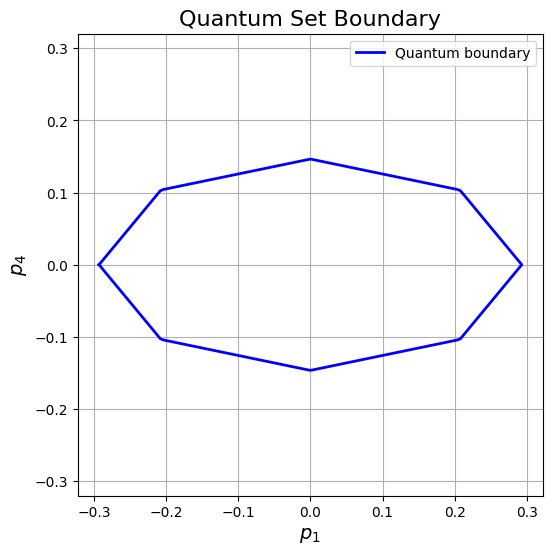

In [ ]:
# Reflect the boundary across the p₄-axis
reflected = boundary[boundary[:, 1] != 0] * np.array([1, -1])
full_boundary = np.vstack([boundary, reflected])

# Sort the points by polar angle to ensure a smooth curve
angles = np.arctan2(full_boundary[:, 1], full_boundary[:, 0])
sorted_idx = np.argsort(angles)
full_boundary = full_boundary[sorted_idx]

# Plotting
plt.figure(figsize=(6, 6))
plt.plot(full_boundary[:, 0], full_boundary[:, 1], 'b-', lw=2, label="Quantum boundary")
plt.xlabel(r"$p_1$", fontsize=14)
plt.ylabel(r"$p_4$", fontsize=14)
plt.title("Dual quantum boundary", fontsize=16)
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.show()

In [5]:
Theta_val = np.pi/8 + np.pi/64
boundary = compute_boundary(Theta_val)

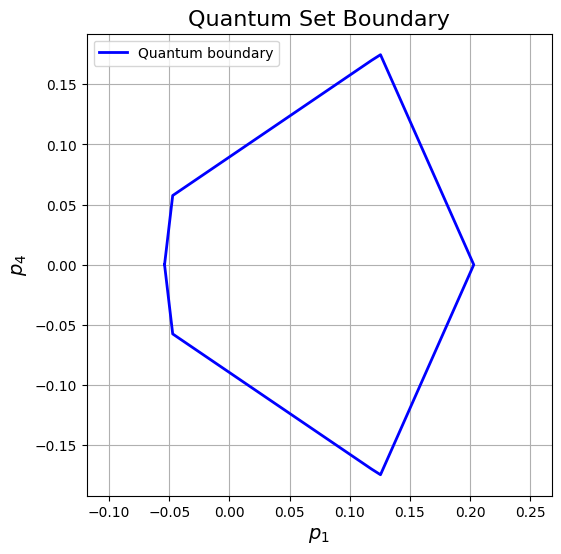

In [ ]:
# Reflect the boundary across the p₄-axis
reflected = boundary[boundary[:, 1] != 0] * np.array([1, -1])
full_boundary = np.vstack([boundary, reflected])

# Sort the points by polar angle to ensure a smooth curve
angles = np.arctan2(full_boundary[:, 1], full_boundary[:, 0])
sorted_idx = np.argsort(angles)
full_boundary = full_boundary[sorted_idx]

# Plotting
plt.figure(figsize=(6, 6))
plt.plot(full_boundary[:, 0], full_boundary[:, 1], 'b-', lw=2, label="Quantum boundary")
plt.xlabel(r"$p_1$", fontsize=14)
plt.ylabel(r"$p_4$", fontsize=14)
plt.title("Dual quantum boundary", fontsize=16)
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.show()

## Plotting local bounds

In [13]:
# Load the JSON file
with open("vertexCoords.json", "r") as f:
    data = json.load(f)

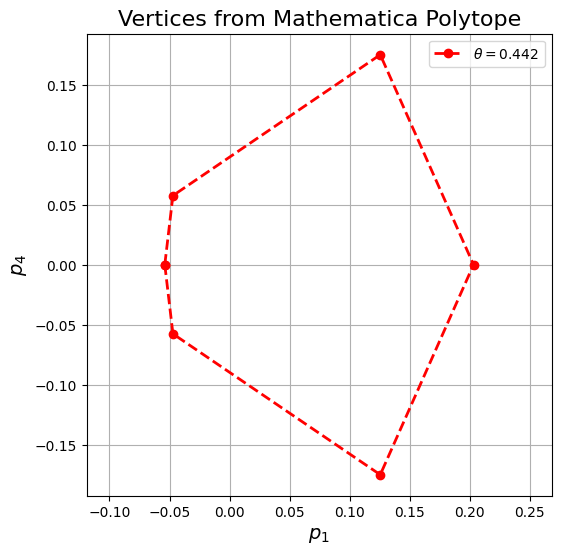

In [ ]:
# Choose the theta index you want to plot (e.g. index = 0 for first theta)
theta_index = 0
theta_value, vertices = data[theta_index]
vertices = np.array(vertices)

# Sort by angle (optional, for aesthetic ordering)
angles = np.arctan2(vertices[:, 1], vertices[:, 0])
sorted_idx = np.argsort(angles)
vertices = vertices[sorted_idx]

# Close the polytope boundary
vertices = np.vstack([vertices, vertices[0]])

# Plot
plt.figure(figsize=(6, 6))
plt.plot(vertices[:, 0], vertices[:, 1], 'ro--', lw=2, label=fr"$\theta = {theta_value:.3f}$")
plt.xlabel(r"$p_1$", fontsize=14)
plt.ylabel(r"$p_4$", fontsize=14)
plt.title("Local polytope", fontsize=16)
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.show()

# Quantum boundaries vs local polytopes

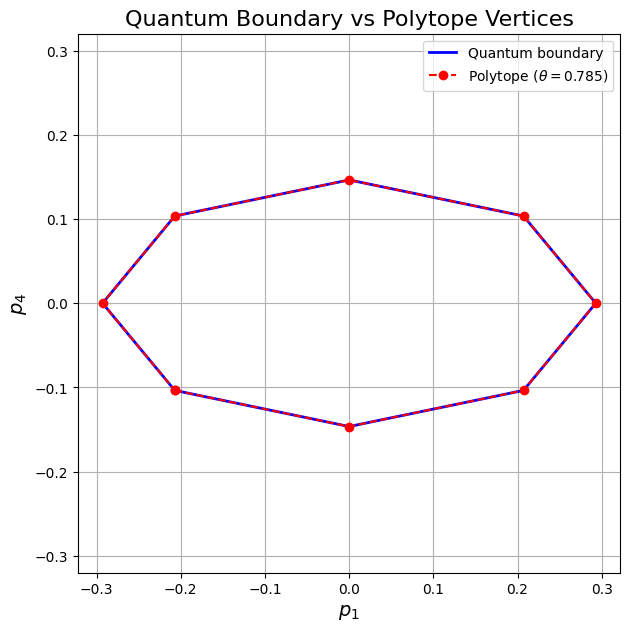

In [ ]:
Theta_val = np.pi / 4
boundary = compute_boundary(Theta_val)

# Exploiting the p4 symmetry
reflected = boundary[boundary[:, 1] != 0].copy()
reflected[:, 1] *= -1
full_boundary = np.vstack([boundary, reflected])

# Ordering by angle
angles = np.arctan2(full_boundary[:, 1], full_boundary[:, 0])
sorted_idx = np.argsort(angles)
full_boundary = full_boundary[sorted_idx]
full_boundary = np.vstack([full_boundary, full_boundary[0]])  # close the boundary

# Plot
plt.figure(figsize=(7, 7))
plt.plot(full_boundary[:, 0], full_boundary[:, 1], 'b-', lw=2, label="Quantum boundary")

# Vertices of the local polytope obtained with Mathematica
tolerance = 1e-4
for theta_value, verts in data:
    if abs(theta_value - Theta_val) < tolerance:
        verts = np.array(verts)
        angles = np.arctan2(verts[:, 1], verts[:, 0])
        sorted_idx = np.argsort(angles)
        verts = verts[sorted_idx]
        verts = np.vstack([verts, verts[0]])  # close the polytope
        plt.plot(verts[:, 0], verts[:, 1], 'ro--', lw=1.5, label=fr"Polytope ($\theta = {Theta_val:.3f}$)")
        break

plt.xlabel(r"$p_1$", fontsize=14)
plt.ylabel(r"$p_4$", fontsize=14)
plt.title("Quantum boundary vs Local polytope", fontsize=16)
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.show()

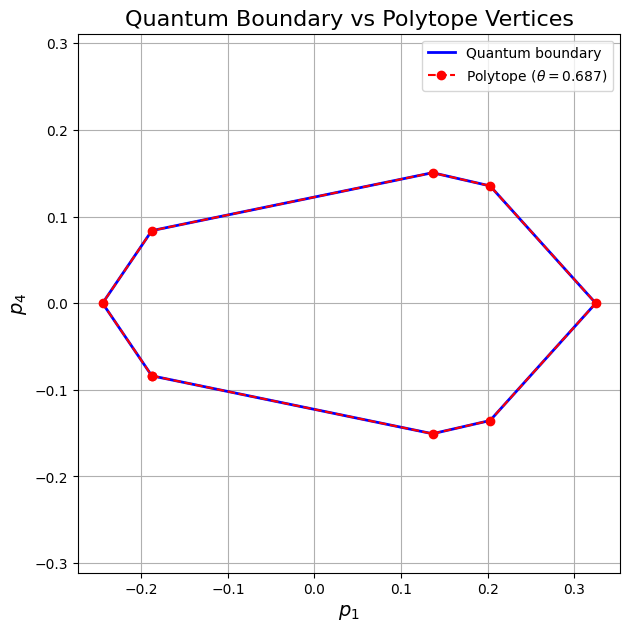

In [ ]:
Theta_val = np.pi/4 - np.pi/32
boundary = compute_boundary(Theta_val)

# Exploiting the p4 symmetry
reflected = boundary[boundary[:, 1] != 0].copy()
reflected[:, 1] *= -1
full_boundary = np.vstack([boundary, reflected])

# Ordering by angle
angles = np.arctan2(full_boundary[:, 1], full_boundary[:, 0])
sorted_idx = np.argsort(angles)
full_boundary = full_boundary[sorted_idx]
full_boundary = np.vstack([full_boundary, full_boundary[0]])  # close the boundary

# Plot
plt.figure(figsize=(7, 7))
plt.plot(full_boundary[:, 0], full_boundary[:, 1], 'b-', lw=2, label="Quantum boundary")

# Vertices of the local polytope obtained with Mathematica
tolerance = 1e-4
for theta_value, verts in data:
    if abs(theta_value - Theta_val) < tolerance:
        verts = np.array(verts)
        angles = np.arctan2(verts[:, 1], verts[:, 0])
        sorted_idx = np.argsort(angles)
        verts = verts[sorted_idx]
        verts = np.vstack([verts, verts[0]])  # close the polytope
        plt.plot(verts[:, 0], verts[:, 1], 'ro--', lw=1.5, label=fr"Polytope ($\theta = {Theta_val:.3f}$)")
        break

plt.xlabel(r"$p_1$", fontsize=14)
plt.ylabel(r"$p_4$", fontsize=14)
plt.title("Quantum boundary vs Local polytope", fontsize=16)
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.show()

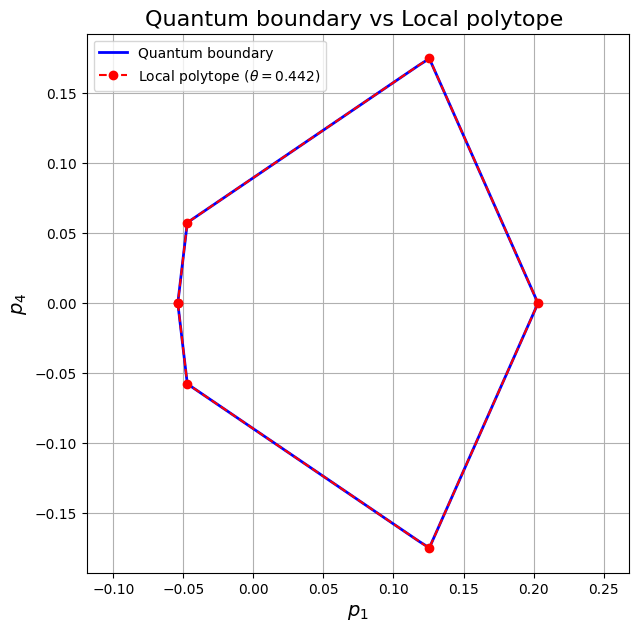

In [23]:
Theta_val = np.pi/8 + np.pi/64
boundary = compute_boundary(Theta_val)

# Exploiting the p4 symmetry
reflected = boundary[boundary[:, 1] != 0].copy()
reflected[:, 1] *= -1
full_boundary = np.vstack([boundary, reflected])

# Ordering by angle
angles = np.arctan2(full_boundary[:, 1], full_boundary[:, 0])
sorted_idx = np.argsort(angles)
full_boundary = full_boundary[sorted_idx]
full_boundary = np.vstack([full_boundary, full_boundary[0]])  # close the boundary

# Plot
plt.figure(figsize=(7, 7))
plt.plot(full_boundary[:, 0], full_boundary[:, 1], 'b-', lw=2, label="Quantum boundary")

# Vertices of the local polytope obtained with Mathematica
tolerance = 1e-4
for theta_value, verts in data:
    if abs(theta_value - Theta_val) < tolerance:
        verts = np.array(verts)
        angles = np.arctan2(verts[:, 1], verts[:, 0])
        sorted_idx = np.argsort(angles)
        verts = verts[sorted_idx]
        verts = np.vstack([verts, verts[0]])  # close the polytope
        plt.plot(verts[:, 0], verts[:, 1], 'ro--', lw=1.5, label=fr"Local polytope ($\theta = {Theta_val:.3f}$)")
        break

plt.xlabel(r"$p_1$", fontsize=14)
plt.ylabel(r"$p_4$", fontsize=14)
plt.title("Quantum boundary vs Local polytope ", fontsize=16)
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.show()